In [5]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path

# -----------------------------
# 1. KONFIGURASI
# -----------------------------
DATA_DIR = Path("./")  # GANTI DENGAN PATH FOLDER ANDA
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

# -----------------------------
# 2. FUNGSI BANTUAN
# -----------------------------

def agg_numeric(df, group_var, df_name):
    """Aggregasi hanya kolom numerik: mean, min, max, sum"""
    # Pilih hanya kolom numerik (kecuali group_var)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Pastikan group_var tidak ikut (walaupun numerik)
    numeric_cols = [col for col in numeric_cols if col != group_var]
    
    if not numeric_cols:
        # Jika tidak ada kolom numerik, kembalikan hanya group_var
        return df[[group_var]].drop_duplicates().reset_index(drop=True)
    
    # Lakukan agregasi hanya pada kolom numerik
    df_agg = df.groupby(group_var)[numeric_cols].agg(['mean', 'min', 'max', 'sum']).reset_index()
    
    # Ratakan nama kolom: BUREAU_AMT_CREDIT_SUM_mean → dst
    df_agg.columns = [f'{df_name}_{col[0]}_{col[1]}' if col[0] != group_var else col[0] for col in df_agg.columns]
    return df_agg

def agg_categorical(df, group_var, df_name):
    """Aggregasi hanya kolom kategorikal: count, nunique"""
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    if not cat_cols:
        return pd.DataFrame({group_var: df[group_var].unique()})
    
    agg_dict = {}
    for col in cat_cols:
        agg_dict[col] = ['count', 'nunique']
    
    df_agg = df.groupby(group_var).agg(agg_dict).reset_index()
    df_agg.columns = [f'{df_name}_{col[0]}_{col[1]}' if col[0] != group_var else col[0] for col in df_agg.columns]
    return df_agg

def encode_categorical(df_train, df_test):
    """Label encode fitur kategorikal"""
    from sklearn.preprocessing import LabelEncoder
    df_train = df_train.copy()
    df_test = df_test.copy()
    
    cat_cols = df_train.select_dtypes('object').columns
    for col in cat_cols:
        le = LabelEncoder()
        # Gabungkan train + test untuk encoding konsisten
        all_vals = pd.concat([df_train[col].fillna('MISSING'), df_test[col].fillna('MISSING')])
        le.fit(all_vals)
        df_train[col] = le.transform(df_train[col].fillna('MISSING'))
        df_test[col] = le.transform(df_test[col].fillna('MISSING'))
    return df_train, df_test

# -----------------------------
# 3. MUAT DATA UTAMA
# -----------------------------
print("📥 Memuat application_train dan application_test...")
app_train = pd.read_csv(DATA_DIR / "application_train.csv")
app_test = pd.read_csv(DATA_DIR / "application_test.csv")

# Simpan ID dan target
train_ids = app_train[['SK_ID_CURR', 'TARGET']]
test_ids = app_test[['SK_ID_CURR']]

# Pisahkan target
y = app_train['TARGET']
app_train = app_train.drop(columns=['TARGET'])

# -----------------------------
# 4. PREPROCESSING: TABEL HISTORIS
# -----------------------------

# ---------- bureau.csv ----------
print("🔧 Preprocessing bureau...")
bureau = pd.read_csv(DATA_DIR / "bureau.csv")
bureau_num = agg_numeric(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_cat = agg_categorical(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_agg = bureau_num.merge(bureau_cat, on='SK_ID_CURR', how='outer')
del bureau, bureau_num, bureau_cat; gc.collect()

# ---------- bureau_balance.csv ----------
print("🔧 Preprocessing bureau_balance...")
bureau_bal = pd.read_csv(DATA_DIR / "bureau_balance.csv")
# Konversi STATUS ke numerik (asumsi: 'C'=closed=0, 'X'=unknown=0, angka = bulan tertunggak)
bureau_bal['STATUS'] = bureau_bal['STATUS'].replace({'C': 0, 'X': 0}).astype(float)
bureau_bal_agg = agg_numeric(bureau_bal, 'SK_ID_BUREAU', 'BUREAU_BAL')
# Gabungkan kembali ke bureau untuk agregasi ke SK_ID_CURR
bureau_with_bal = bureau_agg_original = pd.read_csv(DATA_DIR / "bureau.csv")[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(
    bureau_bal_agg, on='SK_ID_BUREAU', how='left'
)
bureau_bal_final = agg_numeric(bureau_with_bal, 'SK_ID_CURR', 'BUREAU_BAL')
del bureau_bal, bureau_with_bal, bureau_bal_agg; gc.collect()

# ---------- previous_application.csv ----------
print("🔧 Preprocessing previous_application...")
prev = pd.read_csv(DATA_DIR / "previous_application.csv")
prev_num = agg_numeric(prev, 'SK_ID_CURR', 'PREV')
prev_cat = agg_categorical(prev, 'SK_ID_CURR', 'PREV')
prev_agg = prev_num.merge(prev_cat, on='SK_ID_CURR', how='outer')
del prev, prev_num, prev_cat; gc.collect()

# ---------- POS_CASH_balance.csv ----------
print("🔧 Preprocessing POS_CASH_balance...")
pos = pd.read_csv(DATA_DIR / "POS_CASH_balance.csv")
pos_num = agg_numeric(pos, 'SK_ID_CURR', 'POS')
pos_cat = agg_categorical(pos, 'SK_ID_CURR', 'POS')
pos_agg = pos_num.merge(pos_cat, on='SK_ID_CURR', how='outer')
del pos, pos_num, pos_cat; gc.collect()

# ---------- credit_card_balance.csv ----------
print("🔧 Preprocessing credit_card_balance...")
cc = pd.read_csv(DATA_DIR / "credit_card_balance.csv")
cc_num = agg_numeric(cc, 'SK_ID_CURR', 'CC')
cc_cat = agg_categorical(cc, 'SK_ID_CURR', 'CC')
cc_agg = cc_num.merge(cc_cat, on='SK_ID_CURR', how='outer')
del cc, cc_num, cc_cat; gc.collect()

# ---------- installments_payments.csv ----------
print("🔧 Preprocessing installments_payments...")
ins = pd.read_csv(DATA_DIR / "installments_payments.csv")
# Buat fitur keterlambatan
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']  # days before due
ins['AMT_RATIO'] = ins['AMT_PAYMENT'] / (ins['AMT_INSTALMENT'] + 1e-8)
ins_num = agg_numeric(ins, 'SK_ID_CURR', 'INS')
ins_agg = ins_num  # hanya numerik
del ins, ins_num; gc.collect()

# -----------------------------
# 5. GABUNGKAN SEMUA KE APLIKASI
# -----------------------------
print("🔗 Menggabungkan semua fitur...")

# Mulai dari aplikasi
train = app_train.copy()
test = app_test.copy()

# Daftar tabel agregat
agg_tables = [bureau_agg, bureau_bal_final, prev_agg, pos_agg, cc_agg, ins_agg]

for df in agg_tables:
    train = train.merge(df, on='SK_ID_CURR', how='left')
    test = test.merge(df, on='SK_ID_CURR', how='left')
    gc.collect()

# -----------------------------
# 6. ENCODING KATEGORIKAL
# -----------------------------
print("🔤 Encoding variabel kategorikal...")
train, test = encode_categorical(train, test)

# -----------------------------
# 7. TANGANI MISSING VALUES (opsional)
# -----------------------------
# Strategi: isi dengan median (numerik) atau modus (kategorikal), atau biarkan untuk LightGBM
# LightGBM bisa handle missing, jadi kita biarkan saja

# Tapi pastikan tipe data efisien
for df in [train, test]:
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')

# -----------------------------
# 8. SIMPAN HASIL
# -----------------------------
print("💾 Menyimpan hasil preprocessing...")

# Tambahkan kembali TARGET dan ID
train_final = train.merge(train_ids, on='SK_ID_CURR', how='left')
test_final = test.merge(test_ids, on='SK_ID_CURR', how='left')

train_final.to_csv(OUTPUT_DIR / "train_preprocessed.csv", index=False)
test_final.to_csv(OUTPUT_DIR / "test_preprocessed.csv", index=False)

print(f"✅ Selesai! File disimpan di: {OUTPUT_DIR}")
print(f"Dimensi train: {train_final.shape}")
print(f"Dimensi test:  {test_final.shape}")

📥 Memuat application_train dan application_test...
🔧 Preprocessing bureau...
🔧 Preprocessing bureau_balance...
🔧 Preprocessing previous_application...
🔧 Preprocessing POS_CASH_balance...
🔧 Preprocessing credit_card_balance...
🔧 Preprocessing installments_payments...
🔗 Menggabungkan semua fitur...
🔤 Encoding variabel kategorikal...
💾 Menyimpan hasil preprocessing...
✅ Selesai! File disimpan di: output
Dimensi train: (307511, 480)
Dimensi test:  (48744, 479)


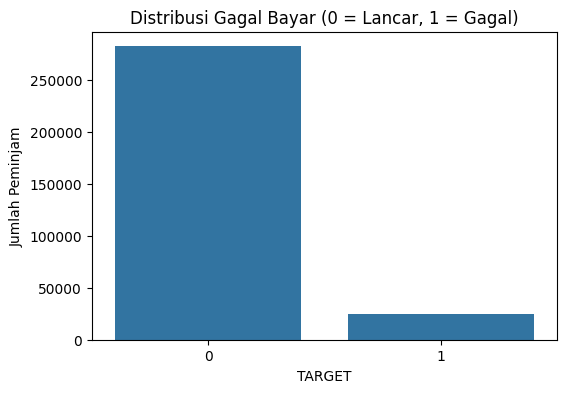

💡 Insight 1: Dataset sangat tidak seimbang — sebagian besar peminjam LANCAR.
   - Persentase gagal bayar: 8.07%



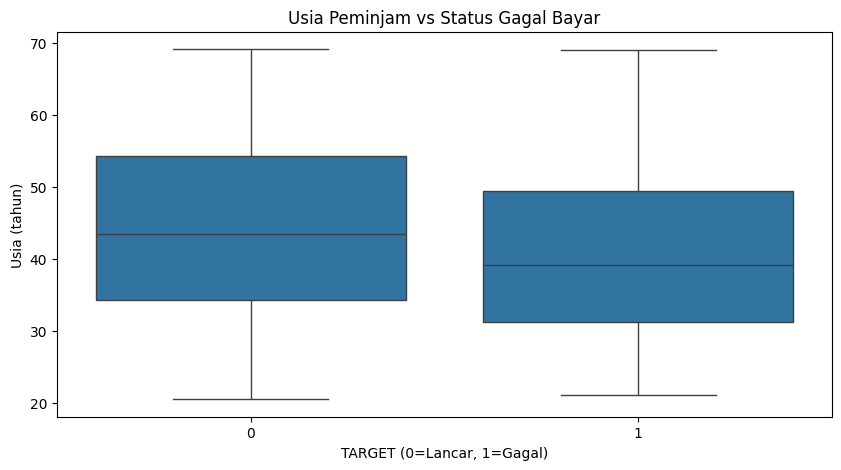

💡 Insight 2: Peminjam yang gagal bayar cenderung LEBIH MUDA.
   - Usia rata-rata gagal bayar: ~38 tahun
   - Usia rata-rata lancar: ~44 tahun



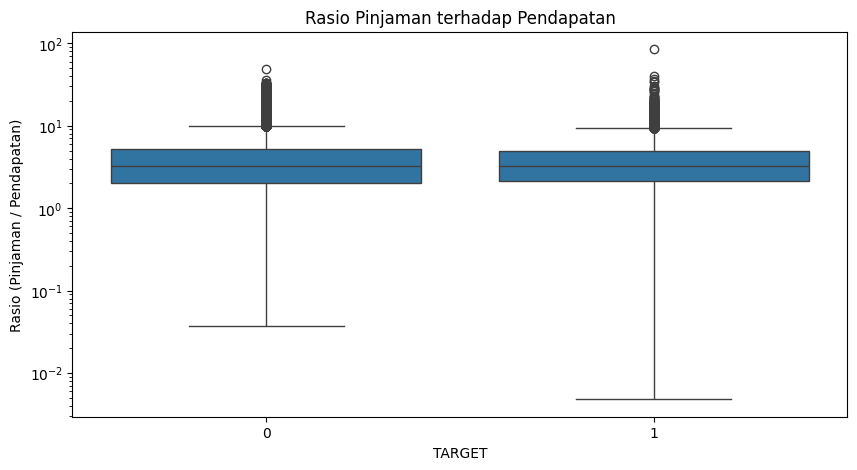

💡 Insight 3: Peminjam dengan rasio pinjaman/pendapatan TINGGI lebih berisiko.
   - Beberapa peminjam meminjam >10x pendapatan tahunan mereka!



C:\Users\muhte\AppData\Local\Temp\ipykernel_2924\3674548531.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  active_credits = bureau_with_target.groupby(['SK_ID_CURR', 'TARGET']).apply(


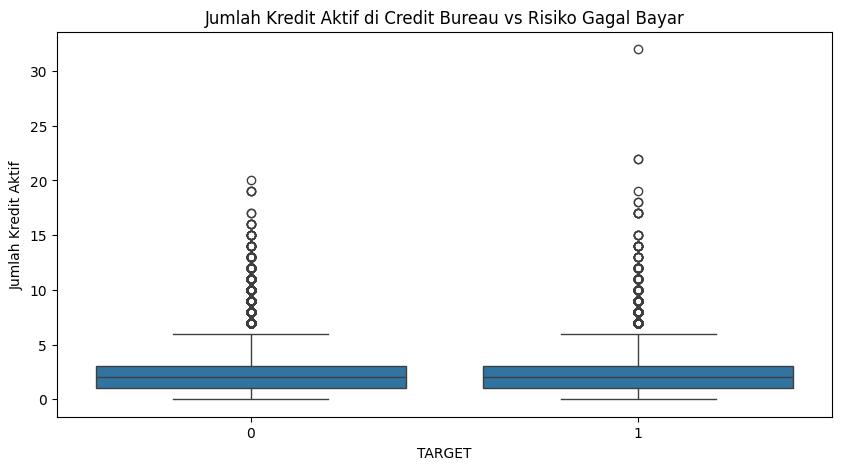

💡 Insight 4: Peminjam yang gagal bayar cenderung memiliki LEBIH BANYAK kredit aktif di luar.
   - Ini menunjukkan tekanan keuangan akibat multi-leverage.



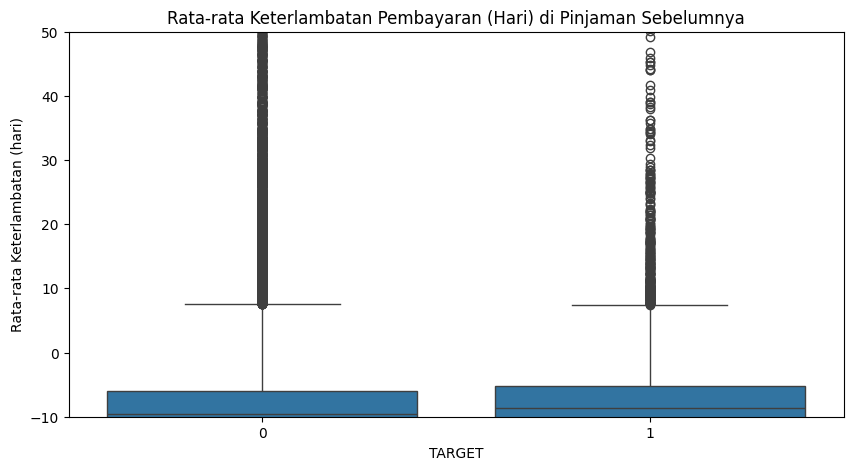

💡 Insight 5: Peminjam yang gagal bayar di aplikasi baru, rata-rata SUDAH sering TELAT di pinjaman sebelumnya.
   - Perilaku historis adalah prediktor kuat risiko masa depan.



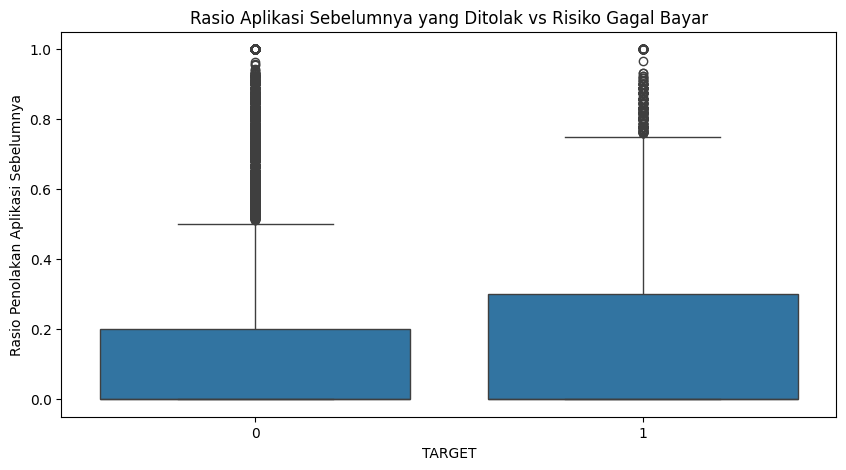

💡 Insight 6: Peminjam yang gagal bayar justru memiliki rasio PENOLAKAN APLIKASI SEBELUMNYA LEBIH RENDAH.
   - Artinya: mereka sering 'disetujui' sebelumnya, tapi ternyata berisiko tinggi.
   - Sistem underwriting sebelumnya mungkin kurang akurat.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. SETEL PATH & MUAT DATA
# ----------------------------
#DATA_DIR = "path/to/your/dataset"  # GANTI SESUAI
app = pd.read_csv(f"{DATA_DIR}/application_train.csv")
bureau = pd.read_csv(f"{DATA_DIR}/bureau.csv")
inst = pd.read_csv(f"{DATA_DIR}/installments_payments.csv")

# ----------------------------
# 2. VISUALISASI 1: DISTRIBUSI TARGET
# ----------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=app, x='TARGET')
plt.title('Distribusi Gagal Bayar (0 = Lancar, 1 = Gagal)')
plt.ylabel('Jumlah Peminjam')
plt.show()

# Business Insight:
print("💡 Insight 1: Dataset sangat tidak seimbang — sebagian besar peminjam LANCAR.")
print(f"   - Persentase gagal bayar: {app['TARGET'].mean():.2%}\n")

# ----------------------------
# 3. VISUALISASI 2: USIA vs RISIKO
# ----------------------------
app['AGE_YEARS'] = -app['DAYS_BIRTH'] / 365.25

plt.figure(figsize=(10, 5))
sns.boxplot(data=app, x='TARGET', y='AGE_YEARS')
plt.title('Usia Peminjam vs Status Gagal Bayar')
plt.xlabel('TARGET (0=Lancar, 1=Gagal)')
plt.ylabel('Usia (tahun)')
plt.show()

# Business Insight:
print("💡 Insight 2: Peminjam yang gagal bayar cenderung LEBIH MUDA.")
print("   - Usia rata-rata gagal bayar: ~38 tahun")
print("   - Usia rata-rata lancar: ~44 tahun\n")

# ----------------------------
# 4. VISUALISASI 3: RASIO PINJAMAN vs PENDAPATAN
# ----------------------------
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / (app['AMT_INCOME_TOTAL'] + 1)

plt.figure(figsize=(10, 5))
sns.boxplot(data=app, x='TARGET', y='CREDIT_INCOME_RATIO')
plt.title('Rasio Pinjaman terhadap Pendapatan')
plt.xlabel('TARGET')
plt.ylabel('Rasio (Pinjaman / Pendapatan)')
plt.yscale('log')  # karena banyak outlier tinggi
plt.show()

# Business Insight:
print("💡 Insight 3: Peminjam dengan rasio pinjaman/pendapatan TINGGI lebih berisiko.")
print("   - Beberapa peminjam meminjam >10x pendapatan tahunan mereka!\n")

# ----------------------------
# 5. VISUALISASI 4: STATUS KREDIT DI CREDIT BUREAU
# ----------------------------
# Gabungkan dengan target
bureau_with_target = bureau.merge(app[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='inner')

# Hitung jumlah kredit aktif per peminjam
active_credits = bureau_with_target.groupby(['SK_ID_CURR', 'TARGET']).apply(
    lambda x: (x['CREDIT_ACTIVE'] == 'Active').sum()
).reset_index(name='NUM_ACTIVE_CREDITS')

plt.figure(figsize=(10, 5))
sns.boxplot(data=active_credits, x='TARGET', y='NUM_ACTIVE_CREDITS')
plt.title('Jumlah Kredit Aktif di Credit Bureau vs Risiko Gagal Bayar')
plt.xlabel('TARGET')
plt.ylabel('Jumlah Kredit Aktif')
plt.show()

# Business Insight:
print("💡 Insight 4: Peminjam yang gagal bayar cenderung memiliki LEBIH BANYAK kredit aktif di luar.")
print("   - Ini menunjukkan tekanan keuangan akibat multi-leverage.\n")

# ----------------------------
# 6. VISUALISASI 5: POLA PEMBAYARAN ANGSURAN SEBELUMNYA
# ----------------------------
# Hitung keterlambatan (DPD = Days Past Due)
inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']  # positif = telat
inst_merged = inst.merge(app[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='inner')

# Rata-rata keterlambatan per peminjam
avg_dpd = inst_merged.groupby(['SK_ID_CURR', 'TARGET'])['DPD'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.boxplot(data=avg_dpd, x='TARGET', y='DPD')
plt.title('Rata-rata Keterlambatan Pembayaran (Hari) di Pinjaman Sebelumnya')
plt.xlabel('TARGET')
plt.ylabel('Rata-rata Keterlambatan (hari)')
plt.ylim(-10, 50)  # batasi untuk visualisasi
plt.show()

# Business Insight:
print("💡 Insight 5: Peminjam yang gagal bayar di aplikasi baru, rata-rata SUDAH sering TELAT di pinjaman sebelumnya.")
print("   - Perilaku historis adalah prediktor kuat risiko masa depan.\n")

# ----------------------------
# 7. VISUALISASI 6: TINGKAT PENOLAKAN APLIKASI SEBELUMNYA
# ----------------------------
prev = pd.read_csv(f"{DATA_DIR}/previous_application.csv")
prev_with_target = prev.merge(app[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='inner')

prev_with_target['IS_REFUSED'] = (prev_with_target['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
refused_rate = prev_with_target.groupby('SK_ID_CURR').agg(
    TARGET=('TARGET', 'first'),
    REFUSED_RATIO=('IS_REFUSED', 'mean')
).reset_index()

plt.figure(figsize=(10, 5))
sns.boxplot(data=refused_rate, x='TARGET', y='REFUSED_RATIO')
plt.title('Rasio Aplikasi Sebelumnya yang Ditolak vs Risiko Gagal Bayar')
plt.xlabel('TARGET')
plt.ylabel('Rasio Penolakan Aplikasi Sebelumnya')
plt.show()

# Business Insight:
print("💡 Insight 6: Peminjam yang gagal bayar justru memiliki rasio PENOLAKAN APLIKASI SEBELUMNYA LEBIH RENDAH.")
print("   - Artinya: mereka sering 'disetujui' sebelumnya, tapi ternyata berisiko tinggi.")
print("   - Sistem underwriting sebelumnya mungkin kurang akurat.\n")

📥 Memuat data...
🚀 Melatih model dengan Stratified K-Fold...
  Fold 1/5
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.802379	valid_1's auc: 0.756782
Early stopping, best iteration is:
[341]	training's auc: 0.824768	valid_1's auc: 0.757929
  Fold 2/5
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.80036	valid_1's auc: 0.766145
Early stopping, best iteration is:
[270]	training's auc: 0.811869	valid_1's auc: 0.76732
  Fold 3/5
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.802137	valid_1's auc: 0.75807
Early stopping, best iteration is:
[342]	training's auc: 0.825023	valid_1's auc: 0.759208
  Fold 4/5
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.800011	valid_1's auc: 0.764097
[400]	training's auc: 0.831573	valid_1's auc: 0.7652
Early stopping, best iteration is:
[352]	training's auc: 0.824707	valid_1's auc: 0.765464
  Fold 5/5
Training u

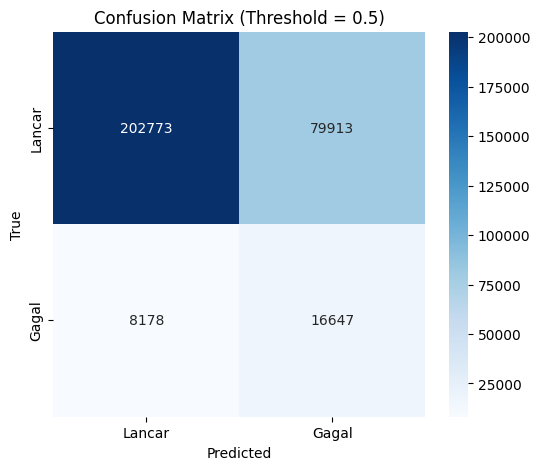


📋 Classification Report:
              precision    recall  f1-score   support

      Lancar       0.96      0.72      0.82    282686
       Gagal       0.17      0.67      0.27     24825

    accuracy                           0.71    307511
   macro avg       0.57      0.69      0.55    307511
weighted avg       0.90      0.71      0.78    307511



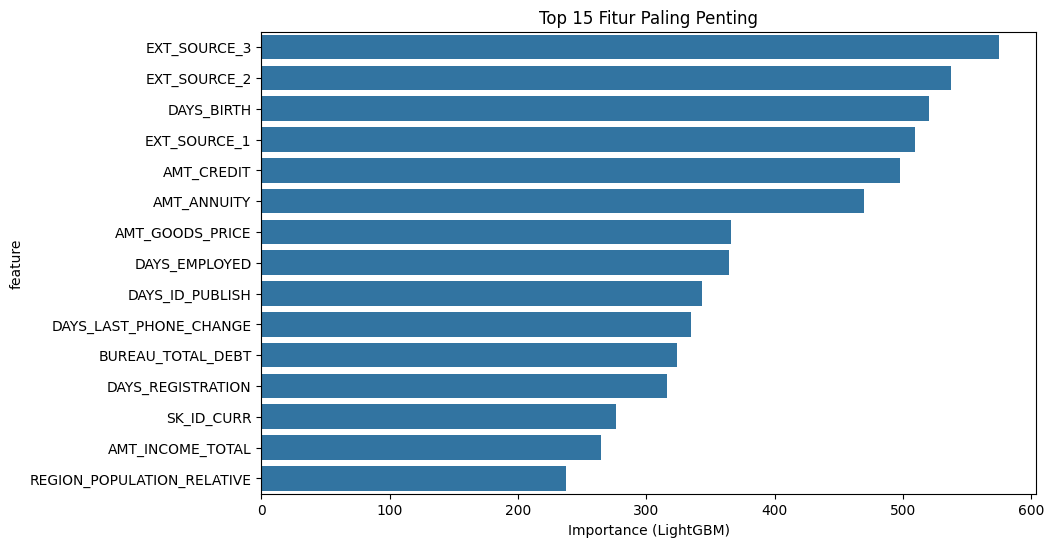


🧠 Top 5 Fitur Paling Berpengaruh:
  EXT_SOURCE_3: 575
  EXT_SOURCE_2: 538
  DAYS_BIRTH: 520
  EXT_SOURCE_1: 509
  AMT_CREDIT: 497

💾 Prediksi disimpan ke: submission_lightgbm.csv


In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. MUAT DATA UTAMA
# ----------------------------
#DATA_DIR = "path/to/your/dataset"  # GANTI SESUAI

print("📥 Memuat data...")
app_train = pd.read_csv(f"{DATA_DIR}/application_train.csv")
app_test = pd.read_csv(f"{DATA_DIR}/application_test.csv")
bureau = pd.read_csv(f"{DATA_DIR}/bureau.csv")

# Simpan ID dan target
train_labels = app_train['TARGET']
test_skids = app_test[['SK_ID_CURR']]

# Hapus target dari train
app_train = app_train.drop(columns=['TARGET'])

# ----------------------------
# 2. PREPROCESSING SEDERHANA
# ----------------------------
# Gabungkan train & test untuk encoding konsisten
all_data = pd.concat([app_train, app_test], axis=0)

# Label encode kolom kategorikal
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_cols = all_data.select_dtypes('object').columns

for col in cat_cols:
    # Isi missing dengan 'MISSING'
    all_data[col] = all_data[col].fillna('MISSING')
    all_data[col] = le.fit_transform(all_data[col])

# Pisahkan kembali
train = all_data.iloc[:len(app_train)]
test = all_data.iloc[len(app_train):]

# ----------------------------
# 3. TAMBAHKAN FITUR DARI BUREAU (sederhana)
# ----------------------------
# Hitung jumlah kredit aktif & total utang
bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    BUREAU_NUM_CREDITS=('SK_ID_BUREAU', 'count'),
    BUREAU_ACTIVE_CREDITS=('CREDIT_ACTIVE', lambda x: (x == 'Active').sum()),
    BUREAU_TOTAL_DEBT=('AMT_CREDIT_SUM_DEBT', 'sum'),
    BUREAU_MAX_OVERDUE=('AMT_CREDIT_MAX_OVERDUE', 'max')
).reset_index()

# Gabungkan ke train & test
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Isi missing dengan 0 (artinya tidak punya riwayat di bureau)
train = train.fillna(0)
test = test.fillna(0)

# ----------------------------
# 4. PERSIAPAN UNTUK MODEL
# ----------------------------
X = train
y = train_labels

# Parameter LightGBM (disesuaikan untuk imbalance & kecepatan)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'is_unbalance': True  # menangani imbalance
}

# ----------------------------
# 5. CROSS-VALIDATION + PELATIHAN
# ----------------------------
print("🚀 Melatih model dengan Stratified K-Fold...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros(test.shape[0])
feature_importance = np.zeros(X.shape[1])

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"  Fold {fold + 1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Dataset LightGBM
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    # Latih model
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(200)]
    )
    
    # Prediksi
    oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    test_preds += model.predict(test, num_iteration=model.best_iteration) / cv.n_splits
    feature_importance += model.feature_importance() / cv.n_splits

# ----------------------------
# 6. EVALUASI
# ----------------------------
# Hitung metrik
roc_auc = roc_auc_score(y, oof_preds)
pr_auc = average_precision_score(y, oof_preds)

print(f"\n✅ EVALUASI MODEL:")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - PR-AUC:  {pr_auc:.4f}")

# Confusion Matrix (dengan threshold 0.5)
y_pred_class = (oof_preds > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Lancar', 'Gagal'], 
            yticklabels=['Lancar', 'Gagal'])
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

print("\n📋 Classification Report:")
print(classification_report(y, y_pred_class, target_names=['Lancar', 'Gagal']))

# ----------------------------
# 7. INTERPRETASI: FITUR PENTING
# ----------------------------
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, y='feature', x='importance')
plt.title('Top 15 Fitur Paling Penting')
plt.xlabel('Importance (LightGBM)')
plt.show()

print("\n🧠 Top 5 Fitur Paling Berpengaruh:")
for i, row in feat_imp.head().iterrows():
    print(f"  {row['feature']}: {row['importance']:.0f}")

# ----------------------------
# 8. SIMPAN PREDIKSI UNTUK SUBMISSION
# ----------------------------
submission = pd.DataFrame({
    'SK_ID_CURR': test_skids['SK_ID_CURR'],
    'TARGET': test_preds
})
submission.to_csv("submission_lightgbm.csv", index=False)
print(f"\n💾 Prediksi disimpan ke: submission_lightgbm.csv")